In [27]:
import momepy
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import shapely

import osmnx as ox

import scripts.consolidate as consolidate
import scripts.snap as snap

import itertools

import numpy as np
from tqdm.notebook import tqdm
import pygeos

import zipfile
import numpy as np
import mapclassify
import copy
from libpysal.weights import Queen, KNN, W

In [30]:
local_crs = 3414

place = "Singapore"

latlng = (1.29, 103.85)
dist = 30000

study_area = gpd.read_file("./Singapore_studyArea.shp").to_crs(epsg=4326)

# assuming your geodataframe is called `gdf` and the geometry column is called `geometry`
study_area = study_area.geometry.unary_union

In [3]:
osm_graph= ox.graph.graph_from_polygon(study_area, network_type='drive')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)

streets = ox.consolidate_intersections(osm_graph, rebuild_graph=True, tolerance=15, dead_ends=False)

streets = ox.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)
streets.head()

osmid  \
u          v          key                                                      
25451915   25451918   0    [166741187, 649636776, 649636777, 717446235, 2...   
25451918   242636478  0                                             22617511   
           1143899970 0                                            166741192   
242636478  4656921454 0                      [37584993, 37584994, 655660141]   
1143899970 1782376557 0                                            200159288   

                           oneway      lanes  ref                    name  \
u          v          key                                                   
25451915   25451918   0      True     [4, 3]  ECP      East Coast Parkway   
25451918   242636478  0      True          1  NaN                     NaN   
           1143899970 0      True          3  ECP      East Coast Parkway   
242636478  4656921454 0      True  [4, 2, 3]  NaN  Tanah Merah Coast Road   
1143899970 1782376557 0      True          3  ECP      East Coast Parkway   

                                 highway maxspeed reversed   length bridge  \
u          v          key                                                    
25451915   25451918   0         motorway       90    False  963.113    yes   
25451918   242636478  0    motorway_link       50    False  278.409    NaN   
           1143899970 0         motorway       90    False  670.252    NaN   
242636478  4656921454 0          primary       60    False  301.106    yes   
1143899970 1782376557 0         motorway       90    False  314.233    NaN   

                                                                    geometry  \
u          v          key                                                      
25451915   25451918   0    LINESTRING (44186.853 35217.240, 44144.233 351...   
25451918   242636478  0    LINESTRING (43649.291 34422.228, 43648.779 344...   
           1143899970 0    LINESTRING (43649.291 34422.228, 43492.918 342...   
242636478  4656921454 0    LINESTRING (43724.424 34208.291, 43746.393 342...   
1143899970 1782376557 0    LINESTRING (43269.766 33872.637, 43113.671 336...   

                          access tunnel junction width  
u          v          key                               
25451915   25451918   0      NaN    NaN      NaN   NaN  
25451918   242636478  0      NaN    NaN      NaN   NaN  
           1143899970 0      NaN    NaN      NaN   NaN  
242636478  4656921454 0      yes    NaN      NaN   NaN  
1143899970 1782376557 0      NaN    NaN      NaN   NaN

In [4]:
osm_graph= ox.graph.graph_from_polygon(study_area, custom_filter='["railway"~"rail|subway|narrow_gauge|monorail"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)

osm_graph = ox.consolidate_intersections(osm_graph, rebuild_graph=True, tolerance=15, dead_ends=False)

rails = ox.graph_to_gdfs(
    osm_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)
rails.head()

osmid   bridge    service  oneway reversed    length  \
u v   key                                                             
0 1   0    142424454  viaduct  crossover   False     True   154.540   
  2   0    558669663  viaduct        NaN   False    False  5672.879   
  3   0    558669663  viaduct        NaN   False     True   503.506   
1 153 0    558669883  viaduct        NaN   False    False    45.852   
  0   0    142424454  viaduct  crossover   False    False   154.540   

                                                    geometry  u_original  \
u v   key                                                                  
0 1   0    LINESTRING (40819.159 34476.905, 40800.607 344...   206656323   
  2   0    LINESTRING (40819.159 34476.905, 40947.408 345...   206656323   
  3   0    LINESTRING (40819.159 34476.905, 40759.620 344...   206656323   
1 153 0    LINESTRING (40677.790 34414.755, 40720.970 344...  1558637809   
  0   0    LINESTRING (40677.790 34414.755, 40699.291 344...  1558637809   

           v_original                  ref                     name tunnel  
u v   key                                                                   
0 1   0    1558637809                  NaN                      NaN    NaN  
  2   0    1558637855  East West Line (EW)  MRT East West Line (EW)    NaN  
  3   0    1558637822  East West Line (EW)  MRT East West Line (EW)    NaN  
1 153 0    1558637836  East West Line (EW)  MRT East West Line (EW)    NaN  
  0   0     206656323                  NaN                      NaN    NaN

In [5]:
waters = []

# Get the water bodies as geometries
water_bodies = ox.geometries_from_polygon(study_area, tags={'natural': 'water'}).set_crs("epsg: 4326").to_crs(local_crs)

# Explode the GeoDataFrame into a GeoSeries of polygons and multipolygons
gs = water_bodies.explode()

# Convert each polygon into a MultiLineString
mls = gs.geometry.boundary

# Convert the MultiLineString into a DataFrame
water_bodies = gpd.GeoDataFrame({'geometry': mls})

# Add a column to specify the polygon ID
water_bodies['polygon_id'] = gs.index

print(water_bodies)

for water_body in water_bodies.geometry:
    # Create a LineString object from the coordinates
    waters.append(water_body)

coastlines = ox.geometries_from_polygon(study_area, tags={'natural': 'coastline'}).set_crs("epsg: 4326").to_crs(local_crs)

coastlines = coastlines[coastlines.geom_type == "LineString"].reset_index(drop=True)

for coastline in coastlines.geometry:
    # Create a LineString object from the coordinates
    waters.append(coastline)

# # Create a GeoDataFrame of the water area boundaries
waters = gpd.GeoDataFrame(geometry=waters)
waters = waters[["geometry"]]
waters.head()

/tmp/ipykernel_18026/1800262028.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = water_bodies.explode()


                                                                  geometry  \
element_type osmid                                                           
way          20250182 0  LINESTRING (37698.921 36379.463, 37801.240 364...   
             20423973 0  LINESTRING (10638.104 45329.526, 10576.655 452...   
             20498763 0  LINESTRING (16251.515 32735.477, 16202.884 325...   
             22721003 0  LINESTRING (20392.301 40523.349, 20411.654 405...   
             22733434 0  LINESTRING (19219.340 37721.260, 19188.801 376...   
...                                                                    ...   
relation     15343835 0  LINESTRING (18748.719 33332.488, 18741.284 333...   
             15343837 0  LINESTRING (18497.165 32564.055, 18502.584 325...   
             15410423 0  LINESTRING (22223.387 29295.415, 22220.839 292...   
             15578756 0  LINESTRING (32275.071 39839.324, 32386.436 398...   
             15578757 0  LINESTRING (32275.071 39839.324, 32275.

,geometry
0,"LINESTRING (37698.921 36379.463, 37801.240 364..."
1,"LINESTRING (10638.104 45329.526, 10576.655 452..."
2,"LINESTRING (16251.515 32735.477, 16202.884 325..."
3,"LINESTRING (20392.301 40523.349, 20411.654 405..."
4,"LINESTRING (19219.340 37721.260, 19188.801 376..."


<Axes: >

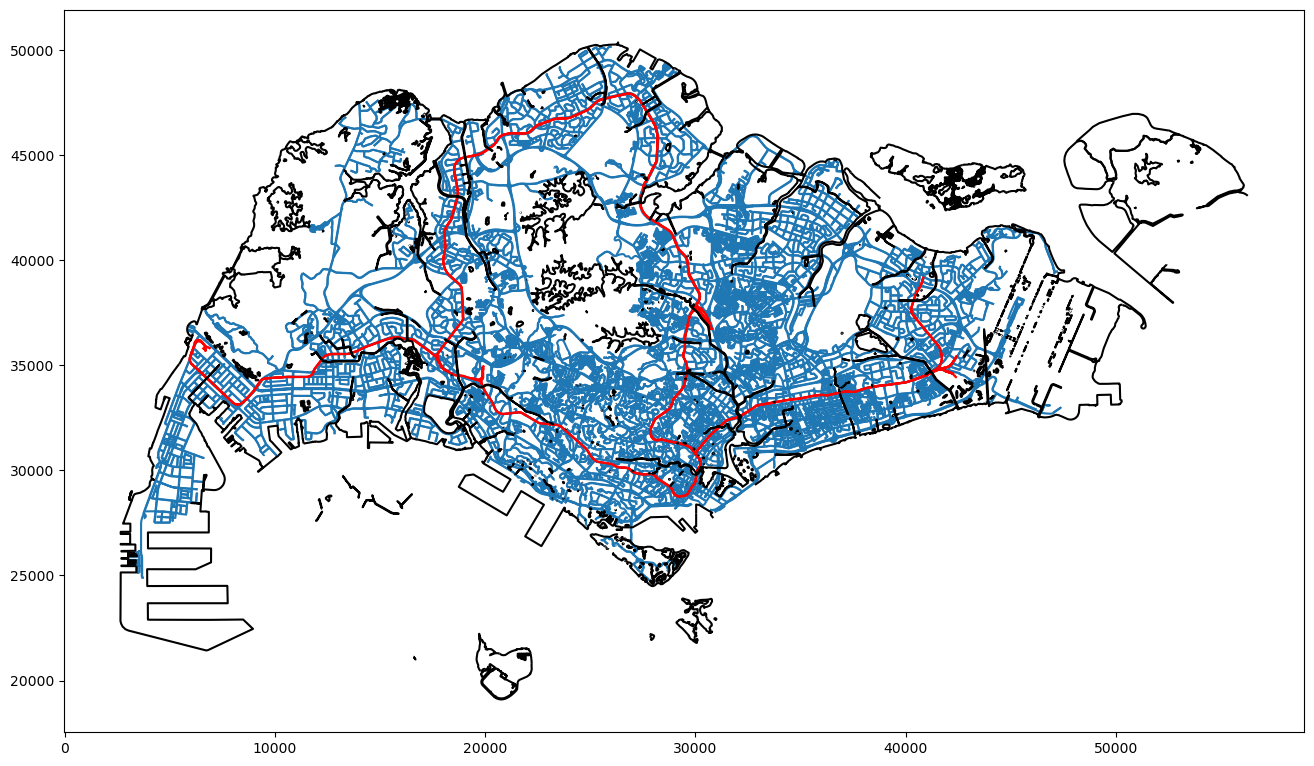

In [6]:
ax = streets.plot(figsize=(16, 16))
rails.plot(ax=ax, color='r')
waters.plot(ax=ax, color='k')

In [8]:
%%time
barriers = pd.concat([streets.geometry, waters.geometry])

CPU times: user 303 ms, sys: 10.4 ms, total: 314 ms
Wall time: 311 ms


/home/virgilxw/miniconda3/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as SVY21 / Singapore TM (the single non-null crs provided).
  warnings.warn(


In [9]:
%%time
unioned = barriers.unary_union

CPU times: user 707 ms, sys: 0 ns, total: 707 ms
Wall time: 707 ms


In [10]:
%%time
polygons = shapely.ops.polygonize(unioned)
enclosures = gpd.array.from_shapely(list(polygons), crs=local_crs)

CPU times: user 1.24 s, sys: 10 ms, total: 1.25 s
Wall time: 1.25 s


In [11]:
%%time
railway_topo = consolidate.topology(rails)

CPU times: user 21.8 ms, sys: 169 µs, total: 21.9 ms
Wall time: 21.1 ms


/home/virgilxw/repo/momepy-test/scripts/consolidate.py:227: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = gdf.reset_index(drop=True).explode().reset_index(drop=True)
/home/virgilxw/repo/momepy-test/scripts/consolidate.py:280: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  final = gpd.GeoSeries(new).explode().reset_index(drop=True)
/home/virgilxw/repo/momepy-test/scripts/consolidate.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS

In [12]:
%%time
closed = snap.close_gaps(railway_topo, tolerance=25)

CPU times: user 32 ms, sys: 3.06 ms, total: 35 ms
Wall time: 33.9 ms


In [13]:
%%time
closed_topo = consolidate.topology(gpd.GeoDataFrame(geometry=closed))

CPU times: user 20.4 ms, sys: 0 ns, total: 20.4 ms
Wall time: 19.1 ms


/home/virgilxw/repo/momepy-test/scripts/consolidate.py:227: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = gdf.reset_index(drop=True).explode().reset_index(drop=True)
/home/virgilxw/repo/momepy-test/scripts/consolidate.py:280: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  final = gpd.GeoSeries(new).explode().reset_index(drop=True)
/home/virgilxw/repo/momepy-test/scripts/consolidate.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


In [14]:
%%time
extended_topo = snap.line_to_line(closed_topo, streets, 25)

CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 70.6 ms


/home/virgilxw/repo/momepy-test/scripts/snap.py:104: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = gdf.reset_index(drop=True).explode().reset_index(drop=True)
/home/virgilxw/repo/momepy-test/scripts/snap.py:163: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  final = gpd.GeoSeries(new_geoms).explode().reset_index(drop=True)
/home/virgilxw/repo/momepy-test/scripts/snap.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


In [16]:
%%time
additional = pd.concat([waters.geometry, extended_topo.geometry])

CPU times: user 688 µs, sys: 81 µs, total: 769 µs
Wall time: 734 µs


In [17]:
%%time
sindex = gpd.GeoSeries(enclosures).sindex
inp, res = sindex.query_bulk(additional.geometry, predicate='intersects')

CPU times: user 239 ms, sys: 0 ns, total: 239 ms
Wall time: 238 ms


In [18]:
%%time
unique = np.unique(res)

CPU times: user 1.13 ms, sys: 133 µs, total: 1.26 ms
Wall time: 1.05 ms


In [22]:
%%time
new = []

for i in tqdm(unique, total=len(unique)):
    poly = enclosures.data[i]  # get enclosure polygon
    crossing = inp[res==i]  # get relevant additional barriers
    buf = pygeos.buffer(poly, 0.01)  # to avoid floating point errors
    crossing_ins = pygeos.intersection(buf, additional.values.data[crossing])  # keeping only parts of additional barriers within polygon
    union = pygeos.union_all(np.append(crossing_ins, pygeos.boundary(poly)))  # union
    polygons = np.array(list(shapely.ops.polygonize(_pygeos_to_shapely(union))))  # shapely.ops.polygonize
    within = pygeos.covered_by(pygeos.from_shapely(polygons), buf)  # keep only those within original polygon

  0%|          | 0/3284 [00:00<?, ?it/s]

CPU times: user 4.43 s, sys: 30.7 ms, total: 4.46 s
Wall time: 4.45 s


In [23]:
%%time
final_enclosures = gpd.GeoSeries(enclosures).drop(unique).append(gpd.GeoSeries(new))

CPU times: user 0 ns, sys: 4.2 ms, total: 4.2 ms
Wall time: 3.62 ms


/home/virgilxw/miniconda3/lib/python3.10/site-packages/geopandas/geoseries.py:622: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = getattr(super(), mtd)(*args, **kwargs)


In [24]:
final_enclosures.shape

(12462,)

In [26]:
%%time
gpd.GeoDataFrame(geometry=final_enclosures, crs=local_crs).to_parquet('./out/singapore/enclosures.pq')

CPU times: user 54.3 ms, sys: 39.4 ms, total: 93.8 ms
Wall time: 92.7 ms


In [65]:
auth = gpd.read_file("./Singapore/Singapore_constituencies.shp").to_crs(local_crs)
auth["index"] = range(len(auth))

In [66]:
buildings = ox.geometries.geometries_from_polygon(study_area, tags={'building':True})
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)
buildings = buildings[["geometry"]].to_crs(local_crs)

In [67]:
auth_buildings = gpd.sjoin(auth, buildings, op='intersects')
count = auth_buildings.groupby('index').size()

/home/virgilxw/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [68]:
auth = auth.merge(count.rename('counts'), left_on='index', right_index=True)

In [69]:
auth.head()

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,snippet,geometry,index,counts
0,RADIN MAS,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaN,NaN,NaN,clampToGround,-1,0,-1,NaN,NaN,NaN,"POLYGON Z ((27057.305 27613.178 0.000, 27014.5...",0,365
1,MOUNTBATTEN,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaN,NaN,NaN,clampToGround,-1,0,-1,NaN,NaN,NaN,"MULTIPOLYGON Z (((37677.048 31460.284 0.000, 3...",1,2305
2,TANJONG PAGAR,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaN,NaN,NaN,clampToGround,-1,0,-1,NaN,NaN,NaN,"POLYGON Z ((29389.455 27129.826 0.000, 29364.7...",2,9694
3,JALAN BESAR,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaN,NaN,NaN,clampToGround,-1,0,-1,NaN,NaN,NaN,"MULTIPOLYGON Z (((32508.046 29401.314 0.000, 3...",3,7928
4,MACPHERSON,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaN,NaN,NaN,clampToGround,-1,0,-1,NaN,NaN,NaN,"POLYGON Z ((33397.910 33024.500 0.000, 33396.8...",4,491


In [70]:
%time w_queen = Queen.from_dataframe(auth)

CPU times: user 54.2 ms, sys: 8.89 ms, total: 63.1 ms
Wall time: 61.3 ms


In [71]:
%time w_k1 = KNN.from_dataframe(auth, k=1)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.9 ms


/home/virgilxw/miniconda3/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  warnings.warn(message)


In [73]:
neighbors = copy.deepcopy(w_queen.neighbors)
for i in w_queen.islands:
    j = w_k1.neighbors[i][0]
    neighbors[i] = [j]
    neighbors[j].append(i)
w = W(neighbors)

NameError: name 'deepcopy' is not defined